In [18]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPClassifier
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
import scipy.optimize as opt
import lucem_illud_2020
import timeit

In [2]:
# Read the data
'''
dtype_dic= {'year': pd.Int64Dtype(), 
            'state_cate': pd.Int64Dtype(),
            'age_cate': pd.Int64Dtype(),
            'age': pd.Int64Dtype(),
            'female_dummy': pd.Int64Dtype(),
            'nonwhite_dummy': pd.Int64Dtype(),
            'marital_dummy': pd.Int64Dtype(),
            'educ_cate': pd.Int64Dtype(),
            'high_school_dummy': pd.Int64Dtype(),
            'college_dummy': pd.Int64Dtype(),
            'graduate_dummy': pd.Int64Dtype(),
            'income_cate': pd.Int64Dtype(),
            'income': pd.Int64Dtype(),
            'precaution_dummy': pd.Int64Dtype(),
            'retire_dummy': pd.Int64Dtype(),
            'fin_par_dummy': pd.Int64Dtype(),
            'math_perceived_cate': pd.Int64Dtype(),
            'fin_perceived_cate': pd.Int64Dtype(),
            'interest_q': pd.Int64Dtype(),
            'inflation_q': pd.Int64Dtype(),
            'bond_q': pd.Int64Dtype(),
            'compound_q': pd.Int64Dtype(),
            'mortgage_q': pd.Int64Dtype(),
            'mutual_q': pd.Int64Dtype()}
'''
df = pd.read_csv("processed_NFCS.csv")
df.head(15)

,ID,year,weights,state_cate,state_dummy_1,state_dummy_2,state_dummy_3,state_dummy_4,state_dummy_5,state_dummy_6,...,precaution_dummy,retire_dummy,fin_par_dummy,math_perceived_cate,fin_perceived_cate,interest_q,inflation_q,bond_q,mortgage_q,mutual_q
0,2012010001,2012,0.363417,24,0,0,0,0,0,0,...,0,0,1,7,6,1,1,3,1,1
1,2012010002,2012,1.173593,10,0,0,0,0,0,0,...,0,0,0,6,5,1,2,2,2,2
2,2012010003,2012,1.577671,23,0,0,0,0,0,0,...,1,0,0,7,5,1,1,2,1,1
3,2012010004,2012,1.577671,14,0,0,0,0,0,0,...,0,0,1,4,4,3,2,2,2,2
4,2012010005,2012,2.167569,44,0,0,0,0,0,0,...,1,0,0,6,6,1,3,2,1,3
5,2012010006,2012,0.513483,25,0,0,0,0,0,0,...,0,0,1,1,6,1,3,3,1,3
6,2012010007,2012,2.234989,31,0,0,0,0,0,0,...,1,1,1,7,6,3,1,3,1,1
7,2012010008,2012,0.753603,22,0,0,0,0,0,0,...,1,0,0,5,3,1,1,3,1,1
8,2012010009,2012,1.576065,5,0,0,0,0,1,0,...,1,0,0,5,4,3,1,1,1,2
9,2012010010,2012,1.466195,4,0,0,0,1,0,0,...,0,0,0,2,5,1,3,3,1,2


In [3]:
# Generate all correct and all incorrect indicator
correct_indicator = (df[['interest_q', 'inflation_q', 'bond_q', 'mortgage_q', 'mutual_q']] == 1).sum(axis=1) == 5
df['q_all_correct'] = correct_indicator
incorrect_indicator = (df[['interest_q', 'inflation_q', 'bond_q', 'mortgage_q', 'mutual_q']] == 1).sum(axis=1) == 0
df['q_all_incorrect'] = incorrect_indicator

In [4]:
# Construct pre-trained overconfidence measure
df['overconfidence'] = np.nan
one_indicator = df['q_all_incorrect'] & (df['math_perceived_cate'] > 5) & (df['fin_perceived_cate'] > 5)
zero_indicator = ((df['q_all_incorrect'] & (df['math_perceived_cate'] < 3) & (df['fin_perceived_cate'] < 3)) | 
                  (df['q_all_correct'] & (df['math_perceived_cate'] > 5) & (df['fin_perceived_cate'] > 5)))
df.loc[one_indicator, 'overconfidence'] = 1
df.loc[zero_indicator, 'overconfidence'] = 0

In [5]:
# Construct a dataframe for machine learning
ml_df = df.loc[df['overconfidence'].notnull(), :].copy()
ml_df

,ID,year,weights,state_cate,state_dummy_1,state_dummy_2,state_dummy_3,state_dummy_4,state_dummy_5,state_dummy_6,...,math_perceived_cate,fin_perceived_cate,interest_q,inflation_q,bond_q,mortgage_q,mutual_q,q_all_correct,q_all_incorrect,overconfidence
46,2012010047,2012,1.679737,5,0,0,0,0,1,0,...,7,6,1,1,1,1,1,True,False,0.0
81,2012010082,2012,2.234989,31,0,0,0,0,0,0,...,7,6,1,1,1,1,1,True,False,0.0
84,2012010085,2012,1.178272,14,0,0,0,0,0,0,...,7,6,1,1,1,1,1,True,False,0.0
99,2012010100,2012,1.697046,50,0,0,0,0,0,0,...,7,6,1,1,1,1,1,True,False,0.0
113,2012010114,2012,1.086083,47,0,0,0,0,0,0,...,7,7,1,1,1,1,1,True,False,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80108,2018037036,2018,0.385926,51,0,0,0,0,0,0,...,6,6,1,1,1,1,1,True,False,0.0
80113,2018037041,2018,0.469334,51,0,0,0,0,0,0,...,7,6,1,1,1,1,1,True,False,0.0
80121,2018037049,2018,0.404002,51,0,0,0,0,0,0,...,6,6,1,1,1,1,1,True,False,0.0
80132,2018037060,2018,0.485971,51,0,0,0,0,0,0,...,7,6,1,1,1,1,1,True,False,0.0


In [6]:
# Construct a dataframe for out-of-sample prediction
pr_df = df.loc[~df['overconfidence'].notnull(), :].copy()
pr_df

,ID,year,weights,state_cate,state_dummy_1,state_dummy_2,state_dummy_3,state_dummy_4,state_dummy_5,state_dummy_6,...,math_perceived_cate,fin_perceived_cate,interest_q,inflation_q,bond_q,mortgage_q,mutual_q,q_all_correct,q_all_incorrect,overconfidence
0,2012010001,2012,0.363417,24,0,0,0,0,0,0,...,7,6,1,1,3,1,1,False,False,NaN
1,2012010002,2012,1.173593,10,0,0,0,0,0,0,...,6,5,1,2,2,2,2,False,False,NaN
2,2012010003,2012,1.577671,23,0,0,0,0,0,0,...,7,5,1,1,2,1,1,False,False,NaN
3,2012010004,2012,1.577671,14,0,0,0,0,0,0,...,4,4,3,2,2,2,2,False,True,NaN
4,2012010005,2012,2.167569,44,0,0,0,0,0,0,...,6,6,1,3,2,1,3,False,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80159,2018037087,2018,0.404002,51,0,0,0,0,0,0,...,4,5,1,3,3,1,1,False,False,NaN
80160,2018037088,2018,0.475130,20,0,0,0,0,0,0,...,2,4,1,3,2,2,2,False,False,NaN
80161,2018037089,2018,0.531368,20,0,0,0,0,0,0,...,5,5,1,1,3,2,2,False,False,NaN
80162,2018037090,2018,0.377318,20,0,0,0,0,0,0,...,7,4,1,3,3,1,1,False,False,NaN


### Logistic Regression

In [7]:
# Construct dependent and independent variable
state_dummy_list = ['state_dummy_{}'.format(i) for i in range(1, 52)]
X_list = state_dummy_list + ['age', 'female_dummy', 'nonwhite_dummy', 'marital_dummy', 'high_school_dummy', 
                             'college_dummy', 'graduate_dummy', 'income', 'math_perceived_cate', 
                             'fin_perceived_cate', 'interest_q', 'inflation_q', 'bond_q', 'mortgage_q', 'mutual_q']
X = ml_df[X_list]
y = ml_df['overconfidence']
X_pred = pr_df[X_list]

In [8]:
# Specify parameter distributions as suggested
param_dist_1 = {'C': sp_uniform(0.1, 10.0)}

overconfidence_clf_1 = LogisticRegression(penalty='l2', solver='lbfgs')

# Run randomized hyperparameter search
start_time = timeit.default_timer()

random_search_1 = RandomizedSearchCV(overconfidence_clf_1, param_distributions=param_dist_1,
                                     n_iter=1000, n_jobs=4, cv=5, random_state=0,
                                     scoring='neg_mean_squared_error')

random_search_1.fit(X, y, sample_weight=ml_df['weights'])

running_time = timeit.default_timer() - start_time

print('The optimal tuning parameter values from randomized hyperparameter search are\n',
      random_search_1.best_params_)
print('The MSE of the optimal results is', -random_search_1.best_score_)
if running_time < 60:
    print('\nTotal time used: {:.0f} s'.format(running_time))
else:
    print('\nTotal time used: {:.0f} min {:.0f} s'.format(running_time // 60, running_time % 60))

The optimal tuning parameter values from randomized hyperparameter search are
 {'C': 4.267109966596578, 'penalty': 'l1'}
The MSE of the optimal results is 0.0003586800573888092

Total time used: 7 min 18 s


In [8]:
# Out of sample prediction
overconfidence_clf_1o = LogisticRegression(C=random_search_1.best_params_['C'], 
                                           penalty='l2',
                                           solver='lbfgs',
                                           random_state=0)

overconfidence_clf_1o.fit(X, y, sample_weight=ml_df['weights'])

y_pred_1 = overconfidence_clf_1o.predict_proba(X_pred)

In [9]:
pr_df['overconfidence_logit'] = y_pred_1[:, 1]

### Random Forest

In [10]:
# Specify parameter distributions as suggested
param_dist_2 = {'n_estimators': sp_randint(10, 200),
                'max_depth': sp_randint(2, 4),
                'min_samples_split': sp_randint(2, 20),
                'min_samples_leaf': sp_randint(2, 20),
                'max_features': sp_randint(1, 4)}

overconfidence_clf_2 = RandomForestClassifier(bootstrap=True, oob_score=True)

# Run randomized hyperparameter search
start_time = timeit.default_timer()

random_search_2 = RandomizedSearchCV(overconfidence_clf_2, param_distributions=param_dist_2,
                                     n_iter=1000, n_jobs=4, cv=5, random_state=0,
                                     scoring='neg_mean_squared_error')

random_search_2.fit(X, y)

running_time = timeit.default_timer() - start_time

print('The optimal tuning parameter values from randomized hyperparameter search are\n',
      random_search_2.best_params_)
print('The MSE of the optimal results is', -random_search_2.best_score_)
if running_time < 60:
    print('\nTotal time used: {:.0f} s'.format(running_time))
else:
    print('\nTotal time used: {:.0f} min {:.0f} s'.format(running_time // 60, running_time % 60))

The optimal tuning parameter values from randomized hyperparameter search are
 {'max_depth': 3, 'max_features': 3, 'min_samples_leaf': 12, 'min_samples_split': 10, 'n_estimators': 12}
The MSE of the optimal results is 0.006097560975609756

Total time used: 26 min 40 s


/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


In [ ]:
# Out of sample prediction
overconfidence_clf_2o = RandomForestClassifier(bootstrap=True, 
                                               oob_score=True,
                                               n_estimators=random_search_2.best_params_['n_estimator'],
                                               max_depth=random_search_2.best_params_['max_depth'],
                                               min_samples_split=random_search_2.best_params_['min_samples_split'],
                                               min_samples_leaf=random_search_2.best_params_['min_samples_leaf'],
                                               max_features=random_search_2.best_params_['max_features'],
                                               random_state=0)

overconfidence_clf_2o.fit(X, y, sample_weight=ml_df['weights'])

y_pred_2 = overconfidence_clf_2o.predict_proba(X_pred)

In [ ]:
pr_df['overconfidence_forest'] = y_pred_2[:, 1]

### Support Vector Machine

In [11]:
# Specify parameter distributions as suggested
param_dist_3 = {'C': sp_uniform(loc=0.1, scale=10.0),
                'gamma': ['scale', 'auto'],
                'shrinking': [True, False]}

overconfidence_clf_3 = SVC(kernel='rbf')

# Run randomized hyperparameter search
start_time = timeit.default_timer()

random_search_3 = RandomizedSearchCV(overconfidence_clf_3, param_distributions=param_dist_3,
                                     n_iter=1000, n_jobs=4, cv=5, random_state=0,
                                     scoring='neg_mean_squared_error')

random_search_3.fit(X, y)

running_time = timeit.default_timer() - start_time

print('The optimal tuning parameter values from randomized hyperparameter search are\n',
      random_search_3.best_params_)
print('The MSE of the optimal results is', -random_search_3.best_score_)
if running_time < 60:
    print('\nTotal time used: {:.0f} s'.format(running_time))
else:
    print('\nTotal time used: {:.0f} min {:.0f} s'.format(running_time // 60, running_time % 60))

The optimal tuning parameter values from randomized hyperparameter search are
 {'C': 2.8883894070106906, 'gamma': 'auto', 'shrinking': False}
The MSE of the optimal results is -0.0

Total time used: 196 min 53 s


In [ ]:
# Out of sample prediction
overconfidence_clf_3o = SVC(kernel='rbf',
                            C=random_search_3.best_params_['C'],
                            gamma=random_search_3.best_params_['gamma'],
                            shrinking=random_search_3.best_params_['shrinking'],
                            random_state=0)

overconfidence_clf_3o.fit(X, y, sample_weight=ml_df['weights'])

y_pred_3 = overconfidence_clf_3o.predict_proba(X_pred)

In [ ]:
pr_df['overconfidence_svm'] = y_pred_3[:, 1]

### Ridge Regression

In [12]:
# Specify parameter distributions as suggested
param_dist_4 = {'alpha': sp_uniform(0.1, 10.0)}

overconfidence_clf_4 = Ridge()

# Run randomized hyperparameter search
start_time = timeit.default_timer()

random_search_4 = RandomizedSearchCV(overconfidence_clf_4, param_distributions=param_dist_4,
                                     n_iter=1000, n_jobs=4, cv=5, random_state=0,
                                     scoring='neg_mean_squared_error')

random_search_4.fit(X, y)

running_time = timeit.default_timer() - start_time

print('The optimal tuning parameter values from randomized hyperparameter search are\n',
      random_search_4.best_params_)
print('The MSE of the optimal results is', -random_search_4.best_score_)
if running_time < 60:
    print('\nTotal time used: {:.0f} s'.format(running_time))
else:
    print('\nTotal time used: {:.0f} min {:.0f} s'.format(running_time // 60, running_time % 60))

The optimal tuning parameter values from randomized hyperparameter search are
 {'alpha': 10.097876950070463}
The MSE of the optimal results is 0.009745304232805565

Total time used: 1 min 43 s


In [ ]:
# Out of sample prediction
overconfidence_clf_4o = Ridge(alpha=random_search_4.best_params_['alpha'],
                              random_state=0)

overconfidence_clf_4o.fit(X, y, sample_weight=ml_df['weights'])

y_pred_4 = overconfidence_clf_4o.predict_proba(X_pred)

In [ ]:
pr_df['overconfidence_ridge'] = y_pred_4[:, 1]

### Lasso Regression

In [13]:
# Specify parameter distributions as suggested
param_dist_5 = {'alpha': sp_uniform(0.1, 10.0)}

overconfidence_clf_5 = Lasso()

# Run randomized hyperparameter search
start_time = timeit.default_timer()

random_search_5 = RandomizedSearchCV(overconfidence_clf_5, param_distributions=param_dist_5,
                                     n_iter=1000, n_jobs=4, cv=5, random_state=25,
                                     scoring='neg_mean_squared_error')

random_search_5.fit(X, y)

running_time = timeit.default_timer() - start_time

print('The optimal tuning parameter values from randomized hyperparameter search are\n',
      random_search_5.best_params_)
print('The MSE of the optimal results is', -random_search_5.best_score_)
if running_time < 60:
    print('\nTotal time used: {:.0f} s'.format(running_time))
else:
    print('\nTotal time used: {:.0f} min {:.0f} s'.format(running_time // 60, running_time % 60))

The optimal tuning parameter values from randomized hyperparameter search are
 {'alpha': 0.1021661566151221}
The MSE of the optimal results is 0.08009352459180479

Total time used: 1 min 34 s


In [ ]:
# Out of sample prediction
overconfidence_clf_5o = Lasso(alpha=random_search_5.best_params_['alpha'],
                              random_state=0)

overconfidence_clf_5o.fit(X, y, sample_weight=ml_df['weights'])

y_pred_5 = overconfidence_clf_5o.predict_proba(X_pred)

In [ ]:
pr_df['overconfidence_lasso'] = y_pred_5[:, 1]

### MLP Classifier

In [14]:
# Specify parameter distributions as suggested
param_dist_6 = {'hidden_layer_sizes': sp_randint(1, 100),
                'activation': ['logistic', 'relu'],
                'alpha': sp_uniform(0.1, 10.0)}

overconfidence_clf_6 = MLPClassifier(solver='lbfgs')

# Run randomized hyperparameter search
start_time = timeit.default_timer()

random_search_6 = RandomizedSearchCV(overconfidence_clf_6, param_distributions=param_dist_6,
                                     n_iter=1000, n_jobs=4, cv=5, random_state=25,
                                     scoring='neg_mean_squared_error')

random_search_6.fit(X, y)

running_time = timeit.default_timer() - start_time 

print('The optimal tuning parameter values from randomized hyperparameter search are\n',
      random_search_6.best_params_)
print('The MSE of the optimal results is', -random_search_6.best_score_)
if running_time < 60:
    print('\nTotal time used: {:.0f} s'.format(running_time))
else:
    print('\nTotal time used: {:.0f} min {:.0f} s'.format(running_time // 60, running_time % 60))

NameError: name 'MLPClassifier' is not defined

In [ ]:
# Out of sample prediction
overconfidence_clf_6o = Lasso(alpha=random_search_6.best_params_['alpha'],
                              hidden_layer_sizes=random_search_6.best_params_['hidden_layer_sizes'],
                              activation=random_search_6.best_params_['activation'],
                              random_state=0)

overconfidence_clf_6o.fit(X, y, sample_weight=ml_df['weights'])

y_pred_6 = overconfidence_clf_6o.predict_proba(X_pred)

In [ ]:
pr_df['overconfidence_mlp'] = y_pred_6[:, 1]

### Compare the MSEs

In [ ]:
address = '~/Overconfidence-Financial-Behaviors/'

In [14]:
# Construct a dataframe for MSEs
MSE_dict = {'method': ['Logistic', 'Forest', 'SVM', 'Ridge', 'Lasso', 'MLP'],
            'MSE': [-random_search_1.best_score_, -random_search_2.best_score_, 
                    -random_search_3.best_score_, -random_search_4.best_score_,
                    -random_search_5.best_score_, -random_search_6.best_score_]}

MSE_df = pd.DataFrame(MSE_dict)
MSE_df.to_csv(address + 'MSE.csv')

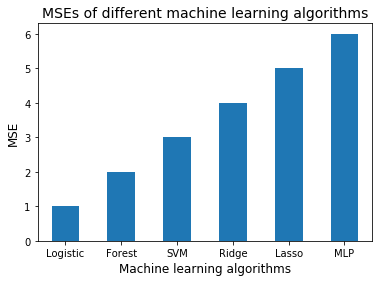

In [31]:
# Draw a bar plot to compare MSEs
ax = MSE_df.plot.bar(x='method', y='MSE', rot=0, legend=None)
ax.set_title("MSEs of different machine learning algorithms", fontsize=14)
ax.set_xlabel("Machine learning algorithms", fontsize=12)
ax.set_ylabel("MSE", fontsize=12)
plt.show()
plt.savefig(address + 'MSE.png')

### Export the dataframe

In [ ]:
# Construct a new dataframe for export
full_df = ml_df.append(pr_df)
hardcode_indicator = ~full_df['overconfidence_logit'].notnull()
full_df.loc[hardcode_indicator, 'overconfidence_logit'] = full_df.loc[hardcode_indicator, 'overconfidence']
full_df.loc[hardcode_indicator, 'overconfidence_forest'] = full_df.loc[hardcode_indicator, 'overconfidence']
full_df.loc[hardcode_indicator, 'overconfidence_svm'] = full_df.loc[hardcode_indicator, 'overconfidence']
full_df.loc[hardcode_indicator, 'overconfidence_ridge'] = full_df.loc[hardcode_indicator, 'overconfidence']
full_df.loc[hardcode_indicator, 'overconfidence_lasso'] = full_df.loc[hardcode_indicator, 'overconfidence']
full_df.loc[hardcode_indicator, 'overconfidence_mlp'] = full_df.loc[hardcode_indicator, 'overconfidence']

In [ ]:
# export the dataframe
full_df.to_csv(address + 'overconfidence_measure.csv')